In [8]:
%load_ext autoreload
%autoreload 2
import relattice as rl
import numpy as np
from scipy.spatial import Delaunay
from matplotlib import pyplot as plt
import  pickle
import matplotlib
import pdb
from scipy import io as spio
import collections

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# You can load the data directly from the mat file that Yoav sent me
# (available here https://drive.google.com/file/d/1gML_Ai3Qdy5KPOoToUxgHejdEkXyCZJe/view?usp=sharing)
d = rl.loadmat('yoav_data.mat')

# The conversion from mat to python objects takes some time. To save time in 
# future runs, you can pickle the result:
pickle.dump(d, open('yoav_data.pkl', 'wb'))
# then you can load the data quickly by:
# pickle.load(open('yoav_data.pkl', 'rb'))

In [39]:
# the pickle file is available at: 
#d = pickle.load(open('yoav_data.pkl','rb'))


In [41]:
points =  np.array([(v['xs'].mean(), v['ys'].mean()) for v in s['holes']]).T
points = points - points.mean(1, keepdims=True)
phi =  np.array([v['phi'] for v in s['holes']]).T
cut_angle =  s['cut_angle']/10
good_points = (phi > cut_angle) | (phi < -cut_angle)

plt.scatter(*points, good_points.astype('d'))

In [29]:
print(dtri.simplices[548])
print(dtri.neighbors[548])

[604 632 591]
[1110 1119  547]


# create movie

In [4]:
d = pickle.load(open('yoav_data.pkl','rb'))
s = rl._todict(d['samples'][0])

In [5]:
points =  np.array([(v['xs'].mean(), v['ys'].mean()) for v in s['holes']]).T
points = points - points.mean(1, keepdims=True)
phi =  np.array([v['phi'] for v in s['holes']]).T
cut_angle =  s['cut_angle']/10
good_points = (phi > cut_angle) | (phi < -cut_angle)

dtri =  Delaunay(points.T)
bad_triangles = np.isin(dtri.simplices, np.where(~good_points)[0]).any(1)

triangles = dtri.points[dtri.simplices]
triangle_centers = triangles.mean(1)
edge_len = np.linalg.norm(triangles - np.roll(triangles, 1, axis=1), axis=2)
triangle_aspect = edge_len.max(axis=1)/edge_len.min(axis=1)
bad_triangles = bad_triangles | (triangle_aspect>1.2)

In [6]:
ij, collisions, svt = rl.relattice(dtri, 619, bad_triangles=np.where(bad_triangles)[0])
Lpoints = s['theo_d_between_holes']*s['px2mm']*(ij@[[1,.5],[0,1]]).T
Lpoints -= np.nanmean(Lpoints,1, keepdims=1)
Lpoints[1]*=-1
Epoints = points


<IPython.core.display.Javascript object>


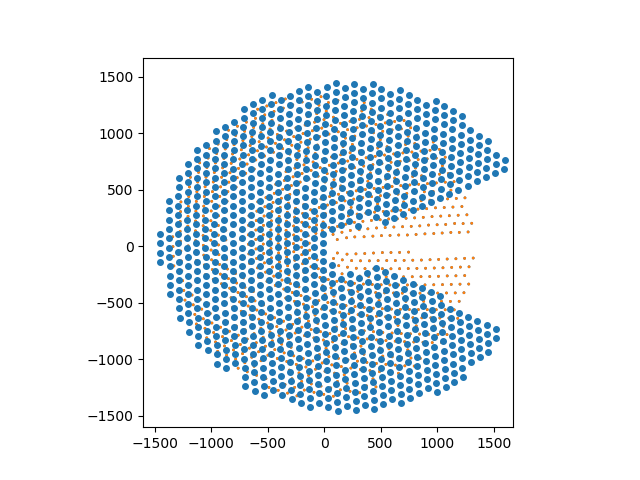

In [37]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

fig, ax = plt.subplots()
ax.set_xlim([-1600,1670])
ax.set_ylim([-1600,1670])
ax.set_aspect('equal')
h = ax.plot(*points,'o', ms=4)
ts = np.concatenate([np.linspace(0,  1, 30),np.linspace(1,  0, 30)])


def animate(i):
    t = ts[i]
    h[0].set_data(tuple(Epoints*(1-t)+Lpoints*t)) 

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(ts))

plt.show()

In [181]:
ani.save('animation.gif', writer='imagemagick', fps=60)

# debug plots

<IPython.core.display.Javascript object>


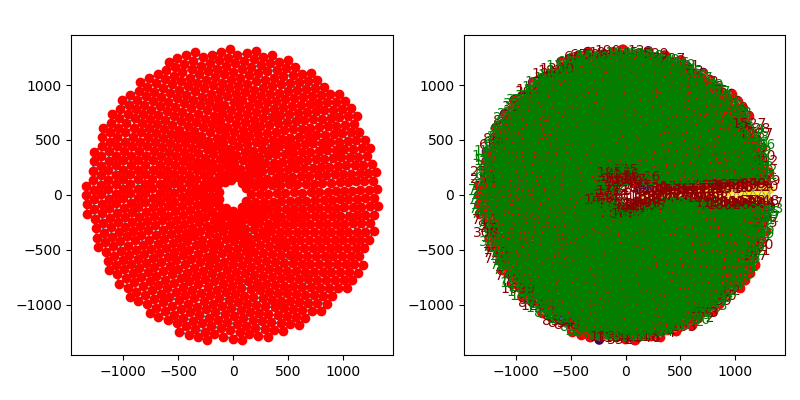

In [33]:
%matplotlib notebook
dtri =  Delaunay(points.T)
bad_triangles = np.isin(dtri.simplices, np.where(~good_points)[0]).any(1)

triangles = dtri.points[dtri.simplices]
triangle_centers = triangles.mean(1)
edge_len = np.linalg.norm(triangles - np.roll(triangles, 1, axis=1), axis=2)
triangle_aspect = edge_len.max(axis=1)/edge_len.min(axis=1)
bad_triangles = bad_triangles | (triangle_aspect>1.2)

tri = matplotlib.tri.Triangulation(*points, triangles=dtri.simplices)
tri.set_mask(bad_triangles)
fig,axs=plt.subplots(1, 2, figsize=(8,4))
axs[0].triplot(tri)
axs[0].plot(*points, 'or')

axs[1].scatter(*points,c=~good_points)
for ax in axs:
    ax.set_aspect(1)
fig.tight_layout()

In [25]:
ij, collisions, svt = rl.relattice(dtri, 619, bad_triangles=np.where(bad_triangles)[0],  verbose=0,
                                  stop_on_collision=4)

<IPython.core.display.Javascript object>


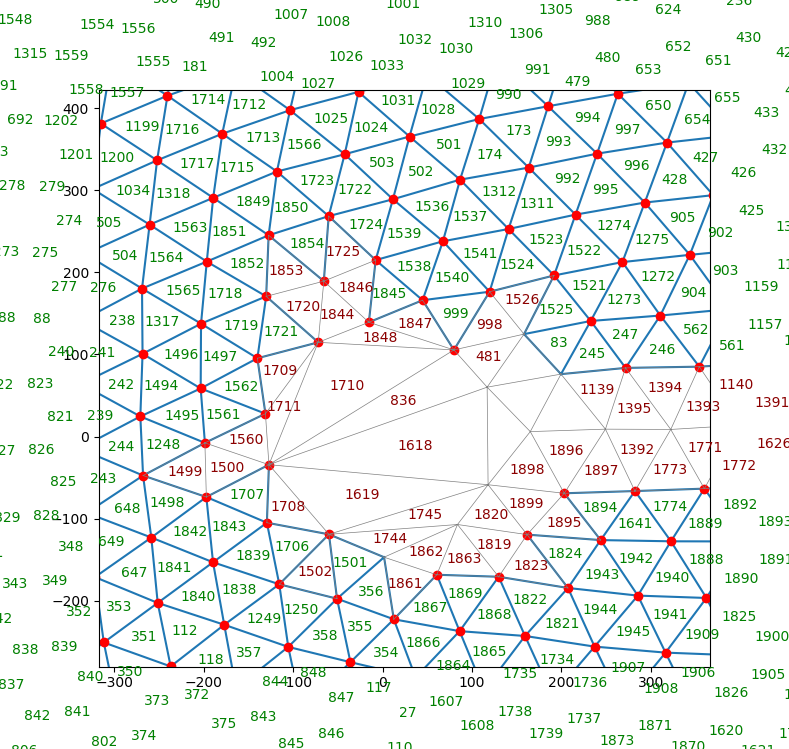

In [35]:
def triplot(tri, ij=None, ax=None, bad_triangles=None, masked_edges=False):
    if ax is None:
        ax = plt.gca()
    ax.triplot(tri)
    if ij is not None:
        solved_points = np.where(~np.isnan(ij).any(1))[0]
        ax.plot(*dtri.points[solved_points].T,'or')
        triangle_inds = np.isin(tri.triangles,  solved_points).any(1)
        for ind in np.where(triangle_inds)[0]:
            ax.text(*triangles[ind].mean(0), ind, ha='center', va='center',
                   c = '#8b0000' if bad_triangles is not None and bad_triangles[ind]
                       else 'g')
    if masked_edges:
        # Plot edges of masked triangles. Shamelessly copied from
        # https://matplotlib.org/3.2.1/_modules/matplotlib/tri/triplot.html
        tri.set_mask(~tri.mask)
        edges =  tri.edges
        tri_lines_x = np.insert(tri.x[edges], 2, np.nan, axis=1)
        tri_lines_y = np.insert(tri.y[edges], 2, np.nan, axis=1)
        tri_lines = ax.plot(tri_lines_x.ravel(), tri_lines_y.ravel(), 
                            color='gray', lw=.5)
        tri.set_mask(~tri.mask)
    return ax
ax = triplot(tri, ij=ij, bad_triangles=bad_triangles, masked_edges=True)